In [1]:
import pandas as pd
import plotly.express as px
import re
import seaborn as sns


### erste gedanken:

- Es ist bis Sitzung 19 komplett vorhanden
- Sitzung 20 nur teilweise bis März 2022, zur 38 sitzung

### zweite Gedanken
vielleicht können nutzer Wörter eingeben, dessen verwendung im dt bundestag sie sehen wollen, zB ORdnugsruf

- es scheint so, dass die Rufe zur Ordnung erst nach den Reden passieren
    - d.h, wenn in einer Rede der Begriff ORdnungsruf anfällt (und diese Rede vom Präsidium kommt, dann muss man diese wahrscheinlich der Partei zuprdnen, welche davor geredet hat (bzw dem politikerinnen))
    - vllt auch in der rede vom präsidium nach Namensnennungen gucken, weil eigentlich nennen die Immer einen Namen

### dritte Gedanken
- Datenbank lokal nachbauen
- https://www.bundestag.de/ajax/filterlist/de/services/opendata/1058442-1058442?limit=10&noFilterSet=true&offset=0 für wp 21
- dafür müsste man den Code anpassen in concat_everything.py und anderen Dateien, um wp 21 zu berücksichtigen, nicht nur die URL hinzufügen
- daten für wp 20 waren zwar da, aber in schon ziemlich anderem Format, ich glaube der neuste Datensatz ist leciht anders aufgebaut und eher nach dem Datensatz von pymdas oder so



In [2]:
factions = pd.read_pickle("../data/factions.pkl")
speeches = pd.DataFrame(pd.read_pickle("../data/speeches.pkl"))
cont_sim = pd.DataFrame(pd.read_pickle("../data/contributions_simplified.pkl"))
cont_ext = pd.DataFrame(pd.read_pickle("../data/contributions_extended.pkl"))
terms = pd.DataFrame(pd.read_pickle("../data/electoral_terms.pkl"))
politicans = pd.DataFrame(pd.read_pickle("../data/politicians.pkl"))

factions

,id,abbreviation,full_name
0,-1,not found,not found
1,0,AfD,Alternative für Deutschland
2,1,BHE,Block der Heimatvertriebenen und Entrechteten
3,2,BP,Bayernpartei
4,3,Grüne,Bündnis 90/Die Grünen
5,4,CDU/CSU,Christlich Demokratische Union Deutschlands/Ch...
6,5,DA,Demokratische Arbeitsgemeinschaft
7,6,DIE LINKE.,DIE LINKE.
8,7,DP,Deutsche Partei
9,8,DP/DBP,Deutsche Partei/Deutsche Partei Bayern


In [3]:
big_party = ["AfD","Grüne" ,"CDU/CSU","DIE LINKE." , "FDP" , "Fraktionslos", "SPD" , "SSW"]

In [4]:
# speeches2 = pd.DataFrame(pd.read_pickle("/home/marvin/Documents/open-discourse/python/data/03_final/speech_content.pkl"))

In [144]:
cont_ext

,id,type,first_name,last_name,politician_id,content,speech_id,text_position,faction_id,faction_name
0,0,Lachen,,,-1,links,6,7,-1,not found
1,1,Personen-Einruf,,hütter,11000979,Nein!,6,2,13,FDP
2,2,Zuruf,,,-1,§ 51!,9,3,20,KPD
3,3,Zuruf,,,-1,links,11,0,-1,not found
4,4,Personen-Einruf,,blücher,11000202,Jawohl!,12,0,13,FDP
...,...,...,...,...,...,...,...,...,...,...
2546207,2546207,Personen-Einruf,götz,frömming,11004722,Das gibt es gar nicht: gerechte Umverteilung!,1072836,2,0,AfD
2546208,2546208,Beifall,,,-1,,1072836,3,23,SPD
2546209,2546209,Beifall,,,-1,,1072836,3,13,FDP
2546210,2546210,Beifall,,,-1,,1072836,3,3,Grüne


In [6]:
color_map = {
    'CDU/CSU': 'black',
    'SPD': '#E3000F',
    'Grüne': '#6AB023',
    'FDP': '#FFD700',
    'DIE LINKE.': '#BE3075',
    'AfD': '#009EE0',
}

In [7]:
speeches["speech_content"] = speeches["speech_content"].str.lower()

In [8]:
# from collections import Counter
# import tqdm
# word_counter = Counter()
# for text in tqdm.tqdm(speeches["speech_content"]):
#     words = re.findall(r'\b[\wäöüÄÖÜß]+\b',text)
#     word_counter.update(words)

In [9]:
# word_counter["corona"]

In [10]:
id_to_name = dict(zip(factions['id'], factions['abbreviation']))


In [11]:
speeches["speech_length"] = speeches["speech_content"].str.len()

In [12]:
speeches["faction_name"] = speeches["faction_id"].map(id_to_name)
cont_ext["faction_name"] = cont_ext["faction_id"].map(id_to_name)

In [13]:
cont_ext.groupby("type").size().reset_index(name="anzahl")

,type,anzahl
0,Beifall,1471300
1,Heiterkeit,19967
2,Lachen,28872
3,Personen-Einruf,733093
4,Unruhe,367
5,Widerspruch,18975
6,Zuruf,223604
7,Zustimmung,50034


In [14]:
cont_ext2 = cont_ext.merge(speeches[["faction_name","id","electoral_term"]], right_on="id",left_on="speech_id")
cont_ext2 = cont_ext2.drop(cont_ext2[(cont_ext2["faction_name_x"] == "DP") & (cont_ext2["electoral_term"] > 3)].index)
# bei electoral Term 10 ist die DP vertreten, dies ist ein einlesefehler, weil damit eig die FDP gemeint ist.
# die DP existiert da garnicht mehr

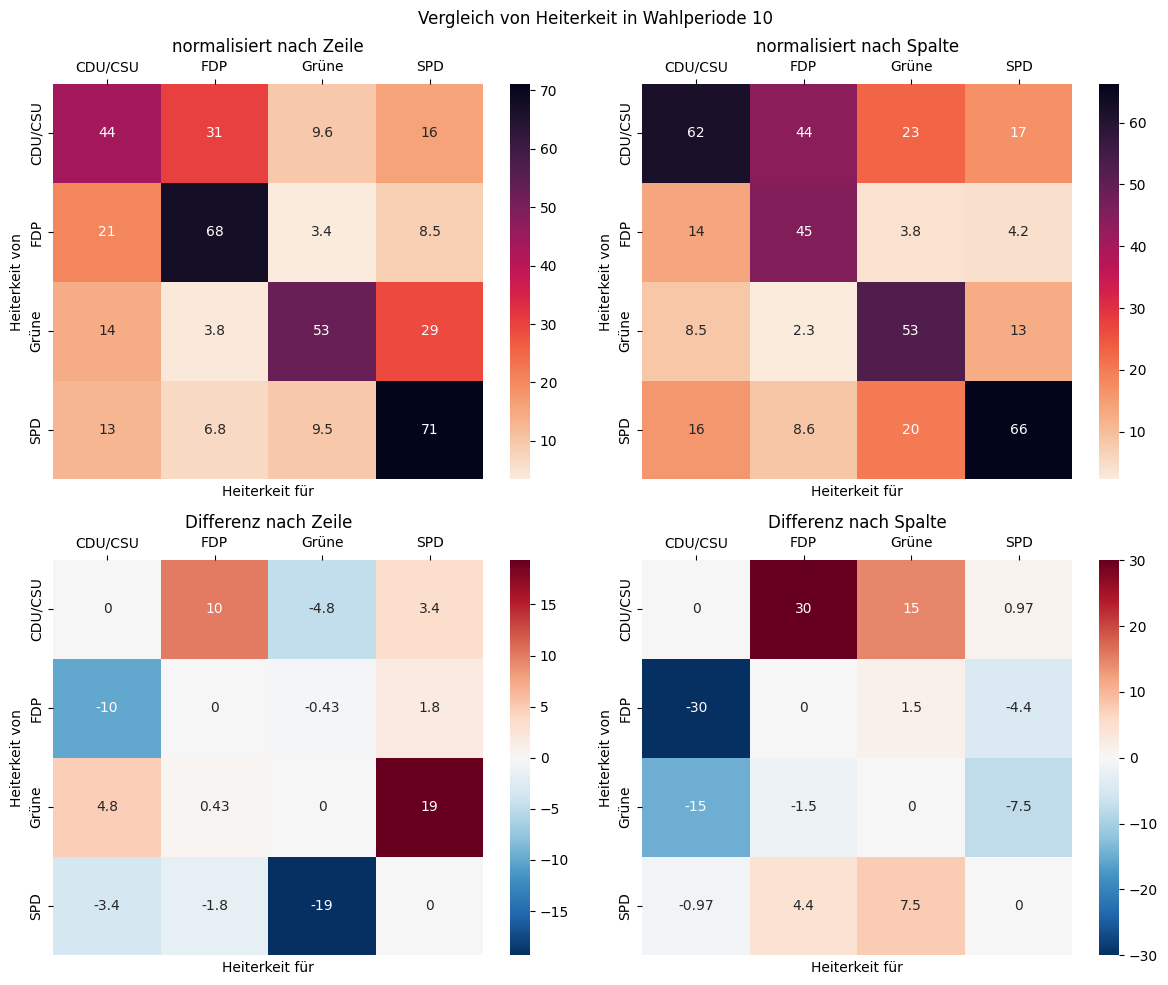

In [111]:
import matplotlib.pyplot as plt
'''
Typen: 

Beifall
Heiterkeit
Lachen
Personen-Einruf
Unruhe
Widerspruch
Zuruf
Zustimmung
'''
WAHLPERIODE = 10
TYP = "Heiterkeit"
normalisiert = True

# nur Beifall raussortieren
beifall = cont_ext2[(cont_ext2["type"] == TYP) & 
                    (cont_ext2["faction_name_x"] != "not found") & 
                    (cont_ext2["faction_name_y"] != "not found") & 
                    (cont_ext2["faction_name_x"] != "Gast") &
                    (cont_ext2["faction_name_y"] != "Gast") & 
                    (cont_ext2["faction_name_x"] != "Fraktionslos") & 
                    (cont_ext2["faction_name_y"] != "Fraktionslos")]
# beifall = cont_ext2[(cont_ext2["type"] == "Beifall") & (cont_ext2["faction_name_x"].isin(big_party))& (cont_ext2["faction_name_y"].isin(big_party))]

# nach partei zählen
grouped = beifall.groupby(["faction_name_x" , "faction_name_y","electoral_term"]).size().reset_index(name="beifälle")

# ne matrix drauß machen
gegenseitig = grouped[grouped["electoral_term"] == WAHLPERIODE].pivot_table(index = "faction_name_x" ,columns= "faction_name_y" ,values="beifälle",aggfunc="sum",fill_value=0)


# quadratische Matrix sicherstellen
all_factions = sorted(set(gegenseitig.index) | set(gegenseitig.columns))
gegenseitig = gegenseitig.reindex(index=all_factions, columns=all_factions, fill_value=0)

# normalisieruen wieviel prozent der Beifälle einer Partei an andere Parteien gehen
genormt_zeile = gegenseitig.div(gegenseitig.sum(axis=1),axis=0) * 100
genormt_spalte = gegenseitig.div(gegenseitig.sum(axis=0),axis=1) * 100

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 1 Zeile, 2 Spalten
fig.suptitle(f"Vergleich von {TYP} in Wahlperiode {WAHLPERIODE}")

sns.heatmap(genormt_zeile if normalisiert else gegenseitig , ax=axes[0][0], annot=True,cmap="rocket_r")
axes[0][0].set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von",title = "normalisiert nach Zeile")
axes[0][0].xaxis.tick_top()


sns.heatmap(genormt_spalte if normalisiert else gegenseitig , ax=axes[0][1], annot=True,cmap="rocket_r")
axes[0][1].set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von",title = "normalisiert nach Spalte")
axes[0][1].xaxis.tick_top()

differenz_zeile = genormt_zeile - genormt_zeile.T
differenz_spalte = genormt_spalte - genormt_spalte.T

sns.heatmap(differenz_zeile,ax=axes[1][0], annot=True,cmap="RdBu_r")
axes[1][0].set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von" , title = "Differenz nach Zeile")
axes[1][0].xaxis.tick_top()

sns.heatmap(differenz_spalte,ax=axes[1][1], annot=True,cmap="RdBu_r")
axes[1][1].set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von", title = "Differenz nach Spalte" )
axes[1][1].xaxis.tick_top()

plt.tight_layout()
plt.show()

### Gedanken dazu:

- man kann supi sehen, wer in welcher Wahlperiode gemeinsam regiert hat
- Beispielhaft vorallem die frühen Perioden 3- 9

- wenn man sich die differenzen anguckt, kann man auch gut sehen, dass niemand wirklich für die AfD applaudiert

- ganz schön viel Widerspruch aus allen Reihen an die AfD
- auch wird viel über die AfD gelacht

- links ist nach Zeile normalisiert, also man sieht zu welcher Partei am meisten Zugerufen wurde
- rechts ist nach SPalte normalisiert, da sieht man von welcher Partei die meisten Zurufe an die eigene Partei kamen


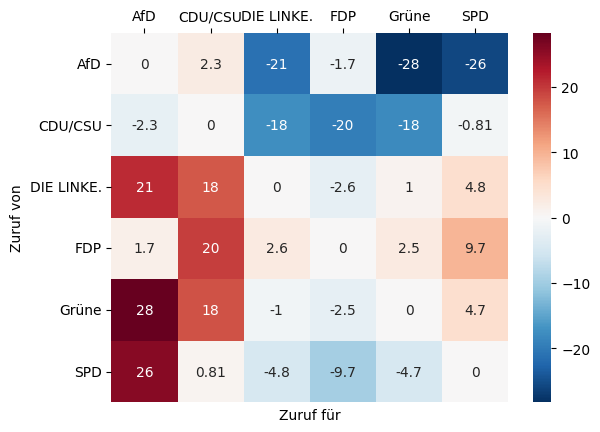

In [106]:
# unterschied wie oft p1 für p2 klatscht, aber p2 für p1 nicht applaudiert
differenz = genormt_zeile - genormt_zeile.T

ax = sns.heatmap(differenz,annot=True,cmap="RdBu_r")
ax.set(xlabel = f"{TYP} für" , ylabel = f"{TYP} von")
ax.xaxis.tick_top()

In [126]:
grouped_all = cont_ext2.groupby(["electoral_term","type"]).size().reset_index(name="anzahl")
grouped_all

,electoral_term,type,anzahl
0,1,Beifall,16361
1,1,Heiterkeit,643
2,1,Lachen,1879
3,1,Personen-Einruf,20713
4,1,Unruhe,126
...,...,...,...
151,20,Lachen,417
152,20,Personen-Einruf,8924
153,20,Widerspruch,267
154,20,Zuruf,2220


In [134]:
fig = px.line(grouped_all,x="electoral_term" , y="anzahl", color="type")
einzug_wahlperioden = {
    "Grüne": 10,
    "DIE LINKE.": 16,
    "AfD": 19
}

farben_linie = {
    "Grüne": "#6AB023",
    "DIE LINKE.": "#BE3075",
    "AfD": "#009EE0"
}

for partei, wahlperiode in einzug_wahlperioden.items():
    fig.add_vline(
        x=wahlperiode,
        line_width=2,
        line_dash="dash",
        line_color=farben_linie[partei],
        annotation_text=f"Einzug {partei}",
        annotation_position="top right",
        annotation_font_color=farben_linie[partei]
    )
fig.show()

### Gedanken dazu:
- Unruhe nimmt stark ab in den ersten Perioden, wahrsceinlich weil Nazis und KPD so langsam rausfliegen
- actually mal den typ nach Partei aufteilen

In [137]:
grouped_faction = cont_ext2.groupby(["electoral_term","type","faction_name_x"]).size().reset_index(name="anzahl")

In [150]:
px.bar(grouped_faction[grouped_faction["type"] == "Heiterkeit"], 
       x="electoral_term",
       y="anzahl",
       color="faction_name_x",
       color_discrete_map=color_map,)

### Gedanken:
- joa, hier sieht man iwi nicht so viel
- generelle Unruhe lässt sich nicht auf einzelne Fraktionen Zuordnen, diese ist eher immer aus einer generellen Richtung gekommen

In [17]:
beifall[beifall["faction_name_x"] == beifall["faction_name_y"]]

,id_x,type,first_name,last_name,politician_id,content,speech_id,text_position,faction_id,faction_name_x,faction_name_y,id_y,electoral_term
9,9,Zustimmung,,,-1,,13,2,23,SPD,SPD,13,1
81,159,Zustimmung,,,-1,,59,48,23,SPD,SPD,59,1
141,140,Zustimmung,,,-1,,59,69,23,SPD,SPD,59,1
142,141,Zustimmung,,,-1,,59,68,23,SPD,SPD,59,1
144,143,Zustimmung,,,-1,,59,64,23,SPD,SPD,59,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2282939,2282939,Zustimmung,Katrin,Budde,11004686,,1015681,12,23,SPD,SPD,1015681,19
2367731,2367731,Zustimmung,grigorios,aggelidis,11004652,,1033554,6,13,FDP,FDP,1033554,19
2373129,2373129,Zustimmung,Ursula,Groden-Kranich,11004280,,1034642,5,4,CDU/CSU,CDU/CSU,1034642,19
2459417,2459417,Zustimmung,marcus,weinberg,11003861,,1055071,1,4,CDU/CSU,CDU/CSU,1055071,19


In [18]:
speeches[speeches["id"] == 298566]

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
298596,298566,139,8,11001022,herr präsident! meine sehr geehrten damen und ...,23,https://dip21.bundestag.de/dip21/btp/08/08139.pdf,Member of Parliament,NA,1979-02-16,4847,SPD


In [19]:
speeches[["faction_id","id"]]

,faction_id,id
0,-1,0
1,-1,1
2,-1,2
3,-1,3
4,-1,4
...,...,...
919518,23,1072832
919519,-1,1072833
919520,4,1072834
919521,-1,1072835


In [20]:
speechs_per_factions = speeches[speeches["position_short"] == "Member of Parliament"].groupby(["electoral_term" , "faction_name"])["speech_length"].sum().reset_index()
speechs_per_factions

,electoral_term,faction_name,speech_length
0,1,BP,1200948
1,1,CDU/CSU,8861600
2,1,DP,2714547
3,1,DRP,81548
4,1,FDP,5079844
...,...,...,...
115,20,DIE LINKE.,912238
116,20,FDP,1521992
117,20,Grüne,1744094
118,20,SPD,2969608


In [21]:
fig = px.bar(
    speechs_per_factions,
    x="electoral_term",
    y="speech_length",
    color="faction_name",
    color_discrete_map=color_map,
    labels={"electoral_term": "Wahlperiode", 
            "speech_length": "Länge der Reden", 
            "faction_name": "Fraktion", 
            "speeches" : "Reden"},
    title="Redelänge von MdB aufgeteilt nach Fraktion",
)
fig.show()

### interpretation

- relativ ausgeglichen viel geredet
- ein trend zu mehr geyappe
- von 40M Buchstaben zu 100M in recent years


In [22]:
cont_sim.tail(10)

,id,text_position,speech_id,content
2190683,936063,6,499517,(Jochen Borchert [CDU/CSU]: Das habe ich auch ...
2190684,936064,5,499517,(Jochen Borchert [CDU/CSU]: Ja!)
2190685,936065,4,499517,"(Beifall bei der SPD, der PDS/Linke Liste sowi..."
2190686,936066,3,499517,(Dr. Nils Diederich [Berlin] [SPD]: Natürlich ...
2190687,936067,2,499517,(Zuruf von der SPD: Hört! Hört!)
2190688,936068,1,499517,(Heiterkeit und Beifall bei der SPD und der CD...
2190689,936069,0,499517,(Beifall bei der SPD und der PDS/Linke Liste -...
2190690,936070,0,499518,(Eduard Oswald [CDU/CSU]: Der Herr Staatssekre...
2190691,936071,4,499519,(Beifall bei der SPD und der PDS/Linke Liste)
2190692,936072,3,499519,(Beifall der Abg. Uta Würfel [F.D.P.])


In [23]:
df_merged = cont_ext.merge(speeches[['id', 'date','electoral_term']], left_on='speech_id', right_on='id', how='left')

In [24]:
präse_reden = speeches[speeches["position_short"] == "Presidium of Parliament"]

In [25]:
rügen_pattern = r" rüge"
rügen = speeches[speeches["speech_content"].str.contains(
    rügen_pattern,
    regex=True    # Regulären Ausdruck verwenden
)]


In [26]:
pattern = r"ordnungsruf|zur ordnung|ich rufe[^.?!]*zur ordnung"
orufe = speeches[speeches["speech_content"].str.contains(
    pattern,
    regex=True    # Regulären Ausdruck verwenden
)]

In [27]:
pattern2 = r"ordnungsruf|ich rufe[^.?!]*zur ordnung"
orufe2 = speeches[speeches["speech_content"].str.contains(
    pattern2,
    regex=True    # Regulären Ausdruck verwenden
)]

In [28]:
redezeit_pattern = r"redezeit"
redezeit = speeches[speeches["speech_content"].str.contains(
    redezeit_pattern,
    regex=True    # Regulären Ausdruck verwenden
)]

In [29]:

# in langen Reden kann es vorkommen, dass gebittet wird, und das wort "schluss" viel später vorkommnt, also garkeinen Bezug auf die redezeit hat
max_dist = 50
# der Term: \b[ .,!?:;]? 
# sorgt dafür, dass würter wie: "schluss" definitiv aufhören, also dass "schlussfolgerung" nicht gezählt wird als Wort

redezeit_pattern_viel = (
    rf"(kommen sie bitte.{{0,{max_dist}}}zum schluss\b[ .,!?:;]?"
    rf"|ich darf sie bitten.{{0,{max_dist}}}(?:zum )?\b(ende|schluss)\b[ .,!?:;]?"
    rf"|ich (muss|möchte) sie (bitten|auffordern).{{0,{max_dist}}}(?:zum )?\b(ende|schluss)\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit (ist|war).{{0,{max_dist}}}\b(abgelaufen|überschritten|vorbei|zu ende|um|beendet)\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit.{{0,{max_dist}}}\b(abgelaufen|überschritten|vorbei|zu ende|um|beendet).{{0,{max_dist}}}\b[ .,!?:;]? (ist|war)"
    rf"|(die|ihre) redezeit.{{0,{max_dist}}}\büberschritten"
    rf"|ich entziehe ihnen das wort\b[ .,!?:;]?"
    rf"|bitte.{{0,{max_dist}}}beenden sie.{{0,{max_dist}}}\bausführungen\b[ .,!?:;]?"
    rf"|(ich erinnere|denken sie).{{0,{max_dist}}}an die redezeit\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit erinnern\b[ .,!?:;]?"
    rf"|über ihrer? redezeit\b[ .,!?:;]?)"
)
redezeit_viel = präse_reden[präse_reden["speech_content"].str.contains(
    redezeit_pattern_viel,
    regex=True    # Regulären Ausdruck verwenden
)]

/tmp/ipykernel_4156/3067899025.py:19: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [30]:
max_dist = 50

# der Term: \b[ .,!?:;]? 
# sorgt dafür, dass würter wie: "schluss" definitiv aufhören, also dass "schlussfolgerung" nicht gezählt wird als Wort

redezeit_pattern_viel2 = (
    rf"(kommen sie bitte.{{0,{max_dist}}}zum schluss\b[ .,!?:;]?"
    rf"|ich darf sie bitten.{{0,{max_dist}}}(?:zum )?\b(ende|schluss)\b[ .,!?:;]?"
    rf"|ich (muss|möchte) sie (bitten|auffordern).{{0,{max_dist}}}(?:zum )?\b(ende|schluss)\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit (ist|war).{{0,{max_dist}}}\b(abgelaufen|überschritten|vorbei|zu ende|um)\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit.{{0,{max_dist}}}\b(abgelaufen|überschritten|vorbei|zu ende|um).{{0,{max_dist}}}\b[ .,!?:;]? (ist|war)"
    rf"|ich entziehe ihnen das wort\b[ .,!?:;]?"
    rf"|bitte.{{0,{max_dist}}}beenden sie.{{0,{max_dist}}}\bausführungen\b[ .,!?:;]?"
    rf"|(ich erinnere|denken sie).{{0,{max_dist}}}an die redezeit\b[ .,!?:;]?"
    rf"|(die|ihre) redezeit erinnern\b[ .,!?:;]?"
    rf"|über ihrer? redezeit\b[ .,!?:;]?)"
)
redezeit_viel2 = präse_reden[präse_reden["speech_content"].str.contains(
    redezeit_pattern_viel2,
    regex=True    # Regulären Ausdruck verwenden
)]

/tmp/ipykernel_4156/2201039146.py:18: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [31]:
only_in_df1 = redezeit_viel[~redezeit_viel["id"].isin(redezeit_viel2["id"])]

In [32]:
rüge_index = redezeit_viel["id"].copy()
rüge_index -= 1
rüge_index
geruegte_reden = speeches[speeches["id"].isin(rüge_index)]

In [33]:
geruegte_reden = geruegte_reden[geruegte_reden["position_short"] == "Member of Parliament"]

In [34]:
geruegte_reden = geruegte_reden.merge(factions,left_on="faction_id" , right_on="id" , how="left")

In [35]:
only_in_df1

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
177,168,7,1,11001993,meine damen und herren! die frau abgeordnete k...,-1,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Presidium of Parliament,vizepräsident,1949-09-22,535,not found
1695,1667,27,1,11001150,"bitte, bringen sie mich nicht in die verlegenh...",-1,https://dip21.bundestag.de/dip21/btp/01/01027.pdf,Presidium of Parliament,präsident,1950-01-18,228,not found
2139,2106,33,1,11001993,"herr abgeordneter, sie haben ihre redezeit sch...",-1,https://dip21.bundestag.de/dip21/btp/01/01033.pdf,Presidium of Parliament,vizepräsident,1950-02-01,80,not found
2414,2389,36,1,11001150,"sie haben ihre redezeit überschritten, und ich...",-1,https://dip21.bundestag.de/dip21/btp/01/01036.pdf,Presidium of Parliament,präsident,1950-02-09,132,not found
2744,2730,40,1,11001150,"herr abgeordneter, ich muß sie nun in aller fo...",-1,https://dip21.bundestag.de/dip21/btp/01/01040.pdf,Presidium of Parliament,präsident,1950-02-23,201,not found
...,...,...,...,...,...,...,...,...,...,...,...,...
908696,1062010,231,19,11004191,"\n\nfrau kollegin, die redezeit ist beendet.",-1,https://dip21.bundestag.de/dip21/btp/19/19231.pdf,Presidium of Parliament,Vizepräsidentin,2021-05-21,42,not found
912300,1065614,12,20,11001235,"\n\nvielen dank, herr kollege gottschalk. – nu...",-1,https://dip21.bundestag.de/dip21/btp/20/20012.pdf,Presidium of Parliament,Vizepräsident,2022-01-14,448,not found
913573,1066894,17,20,11003132,"\n\nfrau fäscher und frau wulf, wenn „präsiden...",-1,https://dip21.bundestag.de/dip21/btp/20/20017.pdf,Presidium of Parliament,Vizepräsidentin,2022-02-17,397,not found
915735,1069095,25,20,11001235,"\n\nvielen dank, frau kollegin renner. – ihre ...",-1,https://dip21.bundestag.de/dip21/btp/20/20025.pdf,Presidium of Parliament,Vizepräsident,2022-03-24,180,not found


In [36]:
langatmer = geruegte_reden.groupby("politician_id").size().reset_index(name="ueberschreitungen")
langatmer


,politician_id,ueberschreitungen
0,-1,56
1,11000001,3
2,11000005,1
3,11000012,1
4,11000013,1
...,...,...
1561,11005246,1
1562,11005255,1
1563,11005260,1
1564,11005262,1


In [37]:
langatmer = langatmer.merge(politicans,left_on="politician_id",right_on="id")

In [38]:
langatmer.sort_values("ueberschreitungen",ascending=False)


,politician_id,ueberschreitungen,id,first_name,last_name,birth_place,birth_country,birth_date,death_date,gender,profession,aristocracy,academic_title
0,-1,56,-1,Not found,,NA,NA,NA,NA,NA,NA,NA,NA
188,11000756,51,11000756,Gregor,Gysi,Berlin,Deutschland,1948-01-16,NA,männlich,"Rechtsanwalt, Autor, Moderator",NA,Dr.
260,11001023,44,11001023,Ulla,Jelpke,Hamburg,Deutschland,1951-06-09,NA,weiblich,Dipl.-Sozialökonomin,NA,NA
714,11002568,40,11002568,Thomas,Wüppesahl,Hamburg,Deutschland,1955-07-09,NA,männlich,Kriminalbeamter,NA,NA
234,11000921,39,11000921,Barbara,Höll,"Coswig / Anhalt, Krs. Roßlau, Bez. Halle",Deutschland,1957-12-26,NA,weiblich,Dipl.-Philosophin,NA,Dr.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,11000058,1,11000058,Dieter,Auch,Stuttgart,Deutschland,1941-04-12,NA,männlich,"Werkzeugmacher, Geschäftsführer",NA,NA
15,11000062,1,11000062,Anneliese,Augustin,Kassel,Deutschland,1930-04-24,2021-11-03,weiblich,Apothekerin,NA,NA
16,11000063,1,11000063,Jürgen,Augustinowitz,Rüthen,Deutschland,1964-06-10,NA,männlich,Bankkaufmann,NA,NA
21,11000080,1,11000080,Egon,Bahr,Treffurt / Thüringen,Deutschland,1922-03-18,2015-08-19,männlich,"Abgeordneter, Bundesminister a. D.",NA,Prof.


In [39]:
mahnungen = geruegte_reden.groupby(["electoral_term" , "abbreviation" , "faction_id"]).size().reset_index(name="mahnungen")

In [40]:
speech_count = speeches.groupby(["electoral_term" , "faction_id"]).size().reset_index(name="speeches")
speech_count[speech_count["faction_id"] != -1]

,electoral_term,faction_id,speeches
1,1,2,400
2,1,4,2510
3,1,7,746
4,1,11,54
5,1,13,1476
...,...,...,...
130,20,3,619
131,20,4,1211
132,20,6,402
133,20,13,541


In [41]:
mahnungen = mahnungen.merge(speech_count,on=["electoral_term" , "faction_id"],how="left")

In [42]:
mahnungen["normalized_mahnungen"] = mahnungen["mahnungen"] / mahnungen["speeches"]


In [43]:
mahnungen

,electoral_term,abbreviation,faction_id,mahnungen,speeches,normalized_mahnungen
0,1,BP,2,15,400,0.037500
1,1,CDU/CSU,4,13,2510,0.005179
2,1,DP,7,10,746,0.013405
3,1,DRP,11,3,54,0.055556
4,1,FDP,13,21,1476,0.014228
...,...,...,...,...,...,...
87,20,DIE LINKE.,6,17,402,0.042289
88,20,FDP,13,22,541,0.040665
89,20,Grüne,3,19,619,0.030695
90,20,SPD,23,30,910,0.032967


In [44]:
normalized = True


# Dein Barplot
fig = px.bar(
    mahnungen,
    x="electoral_term",
    y="normalized_mahnungen" if normalized else "mahnungen",
    color="abbreviation",
    color_discrete_map=color_map,
    labels={"electoral_term": "Wahlperiode", 
            "mahnungen": "Anzahl Mahnungen", 
            "abbreviation": "Fraktion", 
            "speeches" : "Reden"},
    title="Mahnungen pro Wahlperiode und Fraktion" if not normalized else "Mahnungen pro Wahlperiode und Fraktion normalisiert nach Rede",
        hover_data={
        "electoral_term": False,     # ← nicht anzeigen
        "speeches": True,
        "mahnungen": True,
        "normalized_mahnungen": ':.2f' if normalized else False
    }
)

# Linien für erstmaligen Einzug hinzufügen
einzug_wahlperioden = {
    "Grüne": 10,
    "DIE LINKE.": 16,
    "AfD": 19
}

farben_linie = {
    "Grüne": "#6AB023",
    "DIE LINKE.": "#BE3075",
    "AfD": "#009EE0"
}

for partei, wahlperiode in einzug_wahlperioden.items():
    fig.add_vline(
        x=wahlperiode - 0.5,
        line_width=2,
        line_dash="dash",
        line_color=farben_linie[partei],
        annotation_text=f"Einzug {partei}",
        annotation_position="top right",
        annotation_font_color=farben_linie[partei]
    )

fig.show()


# Gedanken dazu:

- wow, die KPD hat aber ordentlich die Geschäftsordnung missachtet
- ab wahlperiode 10 gings ganz schön ab mit Zeitüberschreitungen
- PDS war schein bei Wahlperiode 11 dabei, da 1990 in den Bundestag auch Parteien aus dem Osten dazukamen
- krasser anstieg ab den Grünen (10)
- krasser Anstieg ab Einzug AfD (19)
- nach einbruch von überschreitungen von 16 - 18
- keine Redeüberschreitung nach 1953?
- äh, die normalisierung ist falsch, ich darf das nicht einfach nur aufaddiere, ich muss das für jeden term noch durch die anzahl der fraktionen im parlament teilen


In [45]:
normalizer = speeches.groupby(["electoral_term"]).size().reset_index(name="speeches")

def display_pattern(pattern):
    sentences = speeches[speeches["speech_content"].str.contains(
        pattern,
        regex=True    # Regulären Ausdruck verwenden
    )]
    result = sentences.groupby("electoral_term").size().reset_index(name="orufe_count")
    result["norm_rufe"] = (result["orufe_count"] / normalizer["speeches"]) * normalizer["speeches"].mean()
    return px.bar(result,x="electoral_term",y="orufe_count",title=pattern)

def df_by_term(df, pattern):
    result = df.groupby("electoral_term").size().reset_index(name="orufe_count")
    result["norm_rufe"] = (result["orufe_count"] / normalizer["speeches"]) * normalizer["speeches"].mean()
    return px.bar(result,x="electoral_term",y="orufe_count",title=pattern) 

In [46]:
result = orufe.groupby(["electoral_term","position_short"]).size().reset_index(name="orufe_count")
px.bar(result,x="electoral_term",y="orufe_count",color="position_short")

In [47]:
oruf_pattern = r"ordnungsruf|ich rufe[^.?!]*zur ordnung"
mahnung_pattern = r"ich mahne"
df_by_term(redezeit_viel,redezeit_pattern_viel)

In [48]:
display_pattern(pattern)

In [49]:
orufe

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
53,53,5,1,11001150,"wen meinen sie damit, herr abgeordneter renner...",-1,https://dip21.bundestag.de/dip21/btp/01/01005.pdf,Presidium of Parliament,präsident,1949-09-20,243,not found
115,111,7,1,11001150,"herr abgeordneter reimann, ich habe seit geste...",-1,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Presidium of Parliament,präsident,1949-09-22,1654,not found
121,116,7,1,11000009,meine damen und herren! der herr abgeordnete r...,-1,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Chancellor,NA,1949-09-22,705,not found
178,169,7,1,11000498,meine damen und herren! ursprünglich bestand b...,2,https://dip21.bundestag.de/dip21/btp/01/01007.pdf,Member of Parliament,NA,1949-09-22,13012,BP
383,359,11,1,11001150,"ich habe ferner darauf hinzuweisen, daß die be...",-1,https://dip21.bundestag.de/dip21/btp/01/01011.pdf,Presidium of Parliament,präsident,1949-09-30,1809,not found
...,...,...,...,...,...,...,...,...,...,...,...,...
914457,1067769,20,20,11003132,"\n\nherr kuhle, sorry. ich muss das leider dur...",-1,https://dip21.bundestag.de/dip21/btp/20/20020.pdf,Presidium of Parliament,Vizepräsidentin,2022-03-16,232,not found
914670,1067977,21,20,11003132,\n\nentschuldigung! – frau von storch?\n\n({0}...,-1,https://dip21.bundestag.de/dip21/btp/20/20021.pdf,Presidium of Parliament,Vizepräsidentin,2022-03-17,289,not found
915187,1068498,22,20,11003132,"\n\nfrau von storch, sie rufe ich jetzt zur or...",-1,https://dip21.bundestag.de/dip21/btp/20/20022.pdf,Presidium of Parliament,Vizepräsidentin,2022-03-18,504,not found
917253,1070564,31,20,11004905,\n\nich habe kein foto aus der sitzung veröffe...,0,https://dip21.bundestag.de/dip21/btp/20/20031.pdf,Member of Parliament,NA,2022-04-28,274,AfD


In [50]:
from collections import Counter

# Beispiel: DataFrame mit Spalte 'speech'
# df = pd.DataFrame({'speech': ["...ihre Redezeit beträgt zwei Minuten...", "...ihre Redezeit ist abgelaufen..."]})

# Counter für die Phrasen
phrase_counter = Counter()

# Regex-Pattern: finde 'ihre Redezeit' und hole die nächsten 2 Wörter (inkl. evtl. Bindestrich oder Punkt)
pattern = re.compile(r'ihre redezeit(?:\s+\w+){1,4}')

# Durchlaufe alle Reden
for text in präse_reden["speech_content"]:
    matches = pattern.findall(text)
    for match in matches:
        # Extrahiere die zwei Wörter nach 'ihre Redezeit'
        following_words = re.sub(r'ihre Redezeit\s*', '', match, flags=re.IGNORECASE).strip()
        phrase_counter[following_words] += 1

# Zeige die häufigsten Kombinationen
print(phrase_counter.most_common(20))


[('ist abgelaufen', 907), ('ist zu ende', 353), ('abgelaufen ist', 129), ('ist beendet', 127), ('erinnern', 100), ('ist überschritten', 81), ('ist um', 55), ('ist vorbei', 44), ('verlängern', 38), ('ist weit überschritten', 36), ('zu ende ist', 30), ('überschritten', 29), ('schon überschritten', 28), ('ist leider abgelaufen', 27), ('abgelaufen', 24), ('angerechnet', 24), ('ist schon überschritten', 23), ('schon deutlich überschritten', 23), ('deutlich überschritten', 20), ('weit überschritten', 20)]


In [51]:
import re

# Muster für bekannte Abkürzungen, die nicht als Satzende zählen sollen
abbreviations = [
    "dr.", "prof.", "hr.", "fr.", "dipl.", "ing.", "z.b.", "u.a.", "etc.", 
    "bzw.", "d.h.", "u.v.m.", "i.d.r.", "i.s.v.", "vgl."
]
# Suchmuster für Ordnungsrufe
ordnungsruf_pattern = r"ordnungsruf|zur ordnung|ich rufe[^.?!]*zur ordnung"

for i, speech in only_in_df1.iterrows():
    if speech["position_short"] != "Presidium of Parliament":
        continue

    print(f"Rede Nummer: {speech['id']} from {speech['position_short']}")
    print(speech["date"])
    print(speech["document_url"])

    satz = speech["speech_content"]
    raw_sentences = re.split(r'(?<=[.?!])\s+', satz)

    # Dann Sätze mit Abkürzungen am Ende wieder zusammenfügen
    sentences = []
    buffer = ""
    for s in raw_sentences:
        if any(s.startswith(abbr) or buffer.endswith(abbr) for abbr in abbreviations):
            buffer += " " + s
        else:
            if buffer:
                sentences.append(buffer.strip())
            buffer = s
    if buffer:
        sentences.append(buffer.strip())

    # Sätze mit Ordnungsruf-Muster finden
    matched_sentences = [
        s for s in sentences
        if re.search(redezeit_pattern_viel, s, flags=re.IGNORECASE)
    ]

    for s in matched_sentences:
        print(s)
    # print(satz)
    print("------------------------------------------------------")


Rede Nummer: 168 from Presidium of Parliament
1949-09-22
https://dip21.bundestag.de/dip21/btp/01/01007.pdf
die frau abgeordnete kalinke hat ihre redezeit um fast hundert prozent überschritten.
------------------------------------------------------
Rede Nummer: 1667 from Presidium of Parliament
1950-01-18
https://dip21.bundestag.de/dip21/btp/01/01027.pdf
bitte, bringen sie mich nicht in die verlegenheit, ihnen in aller form das wort zu entziehen, weil sie nach der geschäftsordnung bereits die redezeit von fünf minuten um zwei minuten überschritten haben.
------------------------------------------------------
Rede Nummer: 2106 from Presidium of Parliament
1950-02-01
https://dip21.bundestag.de/dip21/btp/01/01033.pdf
herr abgeordneter, sie haben ihre redezeit schon um das doppelte überschritten.
------------------------------------------------------
Rede Nummer: 2389 from Presidium of Parliament
1950-02-09
https://dip21.bundestag.de/dip21/btp/01/01036.pdf
sie haben ihre redezeit überschrit

In [52]:
'''
redezeit ist vorbei|abgelaufen überschritten
über ihrer redezeit
ihre redezeit ist zu ende
die redezeit war zu ende
redezeit war abgelaufen
dass ihre redezeit um ist
dass sie die redezeit deutlich überschritten haben
kommen Sie bitte zum Schluss
denken Sie bitte an die Redezeit
Kommen Sie bitte zum Schluss

'''

'\nredezeit ist vorbei|abgelaufen überschritten\nüber ihrer redezeit\nihre redezeit ist zu ende\ndie redezeit war zu ende\nredezeit war abgelaufen\ndass ihre redezeit um ist\ndass sie die redezeit deutlich überschritten haben\nkommen Sie bitte zum Schluss\ndenken Sie bitte an die Redezeit\nKommen Sie bitte zum Schluss\n\n'

In [53]:
präse_reden[präse_reden["speech_content"].str.contains(r"über ihrer? redezeit",regex=True)]

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
418241,418211,20,11,11002489,"herr abgeordneter, sie fangen an, über ihre re...",-1,https://dip21.bundestag.de/dip21/btp/11/11020.pdf,Presidium of Parliament,vizepräsident,1987-06-25,68,not found
479282,479247,34,12,11001114,"herr kollege meckel, sie sind jetzt weit über ...",-1,https://dip21.bundestag.de/dip21/btp/12/12034.pdf,Presidium of Parliament,vizepräsident,1991-06-20,61,not found
480589,480542,42,12,11001114,sie machen von einem verfassungsmäßigen recht ...,-1,https://dip21.bundestag.de/dip21/btp/12/12042.pdf,Presidium of Parliament,vizepräsident,1991-09-20,5740,not found
482901,482859,52,12,11001114,"herr kollege schulz, seit punkt vier sind sie ...",-1,https://dip21.bundestag.de/dip21/btp/12/12052.pdf,Presidium of Parliament,vizepräsident,1991-10-30,73,not found
483866,483817,54,12,11002016,"frau kollegin, würden sie dann bitte zum schlu...",-1,https://dip21.bundestag.de/dip21/btp/12/12054.pdf,Presidium of Parliament,vizepräsidentin,1991-11-07,96,not found
...,...,...,...,...,...,...,...,...,...,...,...,...
870805,1024112,97,19,11001235,"\n\nherr kollege, ich habe ihnen das wort entz...",-1,https://dip21.bundestag.de/dip21/btp/19/19097.pdf,Presidium of Parliament,Vizepräsident,2019-05-08,178,not found
878063,1031375,125,19,11003212,"\n\nherr kollege, aber ein kurzer schluss, wei...",-1,https://dip21.bundestag.de/dip21/btp/19/19125.pdf,Presidium of Parliament,Vizepräsidentin,2019-11-08,80,not found
897794,1051105,195,19,11003212,"\n\nherr kollege, sie kriegen gleich auch eine...",-1,https://dip21.bundestag.de/dip21/btp/19/19195.pdf,Presidium of Parliament,Vizepräsident,2020-11-26,110,not found
915781,1069093,25,20,11001235,"\n\nfrau kollegin, sie sind bereits 50 sekunde...",-1,https://dip21.bundestag.de/dip21/btp/20/20025.pdf,Presidium of Parliament,Vizepräsident,2022-03-24,118,not found


In [54]:
# Ordnungsrufe zuordnen:

# def find_oruf(speech):
    # aus den jetzigem, und den drei redebeiträgen davor die redner und zwischenrufer extrahieren
        # alle nachnamen der redners und zwischenrufers extrahieren
        # innerhalb der rede nach dem ordnungsruf nochmal suchen
        # nach matches von nachnamen in der oruf rede suchen, der nachname, welcher am wenigsten weit entfernt ist wird genutzt um diesem Politiker einen ordnungsruf zu erteilen
        


In [55]:
speeches.iloc[505009]

id                                                           504942
session                                                         142
electoral_term                                                   12
politician_id                                              11001114
speech_content    herr kollege reuschenbach, ich habe in 16 jahr...
faction_id                                                       -1
document_url      https://dip21.bundestag.de/dip21/btp/12/12142.pdf
position_short                              Presidium of Parliament
position_long                                         vizepräsident
date                                                     1993-03-03
speech_length                                                   750
faction_name                                              not found
Name: 505009, dtype: object

In [56]:
cont_ext[cont_ext["speech_id"] == 504939]

,id,type,first_name,last_name,politician_id,content,speech_id,text_position,faction_id,faction_name
894175,894175,Personen-Einruf,peter w,reuschenbach,11001827,Sie sind ein Heuchler!,504939,8,23,SPD
894176,894176,Zuruf,,,-1,Die Menschen sind schon verunsichert! -,504939,8,23,SPD
894177,894177,Beifall,,,-1,,504939,7,4,CDU/CSU
894178,894178,Beifall,,,-1,,504939,7,13,FDP
894179,894179,Widerspruch,,,-1,,504939,6,23,SPD
894180,894180,Beifall,,,-1,,504939,6,4,CDU/CSU
894181,894181,Beifall,,,-1,,504939,6,13,FDP
894182,894182,Zuruf,,,-1,,504939,5,23,SPD
894183,894183,Zuruf,,,-1,"Wissen Sie, wie die ABM-Ausschüsse besetzt sin...",504939,5,23,SPD
894184,894184,Personen-Einruf,ina,albowitz,11000022,Da stellt sich die strafrechtliche Frage!,504939,4,13,FDP


In [57]:
speeches["date"] = pd.to_datetime(speeches["date"])


In [58]:
normalizer = speeches.groupby(["electoral_term"]).size().reset_index(name="speeches")
result = orufe.groupby("electoral_term").size().reset_index(name="orufe_count")
result["norm_rufe"] = (result["orufe_count"] / normalizer["speeches"]) * normalizer["speeches"].mean()

In [59]:
result.columns

Index(['electoral_term', 'orufe_count', 'norm_rufe'], dtype='object')

In [60]:
px.bar(result,x="electoral_term",y=result.columns)

In [61]:
cont_ext.shape

(2546212, 10)

In [62]:
test = speeches.value_counts(["faction_id"]).reset_index()

In [63]:
test["name"] = test["faction_id"].map(id_to_name)
test

,faction_id,count,name
0,-1,539649,not found
1,4,129767,CDU/CSU
2,23,120770,SPD
3,13,52971,FDP
4,3,38987,Grüne
5,6,17365,DIE LINKE.
6,22,7058,PDS
7,0,5288,AfD
8,16,1982,Fraktionslos
9,20,1782,KPD


In [64]:
cont_sim.tail()

,id,text_position,speech_id,content
2190688,936068,1,499517,(Heiterkeit und Beifall bei der SPD und der CD...
2190689,936069,0,499517,(Beifall bei der SPD und der PDS/Linke Liste -...
2190690,936070,0,499518,(Eduard Oswald [CDU/CSU]: Der Herr Staatssekre...
2190691,936071,4,499519,(Beifall bei der SPD und der PDS/Linke Liste)
2190692,936072,3,499519,(Beifall der Abg. Uta Würfel [F.D.P.])


In [65]:
max_sessions = speeches.groupby("electoral_term")

In [66]:
max_sessions["session"].max()

electoral_term
1     282
2     227
3     168
4     198
5     247
6     199
7     259
8     230
9     142
10    256
11    236
12    243
13    248
14    253
15    187
16    233
17    253
18    245
19    239
20     38
Name: session, dtype: int64

In [67]:
last_speeches = speeches.loc[max_sessions["id"].idxmax()]
last_speeches

,id,session,electoral_term,politician_id,speech_content,faction_id,document_url,position_short,position_long,date,speech_length,faction_name
29024,28905,282,1,11000438,mein sehr verehrter herr kollege löbe! meine d...,-1,https://dip21.bundestag.de/dip21/btp/01/01282.pdf,Presidium of Parliament,präsident,1953-07-29,8053,not found
55092,54986,227,2,11000669,"meine damen und herren, weitere erklärungen na...",-1,https://dip21.bundestag.de/dip21/btp/02/02227.pdf,Presidium of Parliament,präsident,1957-08-29,11518,not found
77903,77809,168,3,11000669,"meine damen und herren, namens des hauses spre...",-1,https://dip21.bundestag.de/dip21/btp/03/03168.pdf,Presidium of Parliament,präsident,1961-08-22,1070,not found
119097,119022,198,4,11000669,keine weiteren wortmeldungen. die aussprache i...,-1,https://dip21.bundestag.de/dip21/btp/04/04198.pdf,Presidium of Parliament,präsident,1965-07-23,130,not found
173234,173129,247,5,11001529,herr präsident! meine damen und herren! wir ha...,23,https://dip21.bundestag.de/dip21/btp/05/05247.pdf,Member of Parliament,NA,1969-07-03,13358,SPD
208926,208704,199,6,11002270,herr präsident! meine damen und herren! dann m...,4,https://dip21.bundestag.de/dip21/btp/06/06199.pdf,Member of Parliament,NA,1972-09-22,14051,CDU/CSU
266057,266036,259,7,11002033,"meine damen und herren, weitere erklärungen zu...",-1,https://dip21.bundestag.de/dip21/btp/07/07259.pdf,Presidium of Parliament,vizepräsident,1976-12-08,11058,not found
318353,318338,230,8,11001299,ing.oldenstädt\nfrau pack petersen pfeifer\npi...,-1,https://dip21.bundestag.de/dip21/btp/08/08230.pdf,Presidium of Parliament,vizepräsident,1980-07-04,5104,not found
349064,349013,142,9,11002281,"herr staatspräsident, für ihre ansprache danke...",-1,https://dip21.bundestag.de/dip21/btp/09/09142.pdf,Presidium of Parliament,präsident,1983-01-20,1065,not found
413889,413882,256,10,11001025,"meine damen und herren, wir kommen zur einzelb...",-1,https://dip21.bundestag.de/dip21/btp/10/10256.pdf,Presidium of Parliament,präsident,1986-12-11,12330,not found


In [68]:
cont_ext[cont_ext["speech_id"] == 846685]

,id,type,first_name,last_name,politician_id,content,speech_id,text_position,faction_id,faction_name
2209534,2209534,Beifall,,,-1,,846685,2,4,CDU/CSU
2209535,2209535,Beifall,,,-1,,846685,2,23,SPD
2209536,2209536,Beifall,,,-1,,846685,2,3,Grüne
2209537,2209537,Beifall,,,-1,,846685,2,6,DIE LINKE.


In [69]:
cont_ext

,id,type,first_name,last_name,politician_id,content,speech_id,text_position,faction_id,faction_name
0,0,Lachen,,,-1,links,6,7,-1,not found
1,1,Personen-Einruf,,hütter,11000979,Nein!,6,2,13,FDP
2,2,Zuruf,,,-1,§ 51!,9,3,20,KPD
3,3,Zuruf,,,-1,links,11,0,-1,not found
4,4,Personen-Einruf,,blücher,11000202,Jawohl!,12,0,13,FDP
...,...,...,...,...,...,...,...,...,...,...
2546207,2546207,Personen-Einruf,götz,frömming,11004722,Das gibt es gar nicht: gerechte Umverteilung!,1072836,2,0,AfD
2546208,2546208,Beifall,,,-1,,1072836,3,23,SPD
2546209,2546209,Beifall,,,-1,,1072836,3,13,FDP
2546210,2546210,Beifall,,,-1,,1072836,3,3,Grüne


In [70]:
content = last_speeches.iloc[0]["speech_content"]